### Making data cubes 


Andressa Wille 


andressaw2@gmail


28/01/2026

* This is a tutorial on how to cut a region into multiple filters and create a data cube. The functions used are in datacube.py. Here we are using data from Abell 2744.

In [36]:
import glob
import os
from regions import Regions
import pandas as pd
import matplotlib.pyplot as plt
from reproject import reproject_interp
import importlib
from datacube import *
importlib.reload(datacube)

<module 'datacube' from '/home/andressa/github/fits/datacube.py'>

##### 1) Cut regions 
Cut galaxies or any region of of interest in a field. Define one (or more than one) region in DS9 in (shape: box) and save the .reg file.

In [8]:
fits_dir = '/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/'
reg_path = '/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/galaxies.reg'
out_dir  = '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/'

os.makedirs(out_dir, exist_ok=True)

In [9]:
fits_files = sorted(glob.glob(os.path.join(fits_dir, '*.fits')))

# Read regions
regions = Regions.read(reg_path, format='ds9')
print("Number of regions to cut:", len(regions))


# Crop fits by region and organize by instrument 
for i, reg in enumerate(regions):

    gal = reg.meta.get("text", f"region_{i}")
    print(f"\nProcessing region: {gal}")

    for fpath in fits_files:

        fname = os.path.basename(fpath)
        filt  = get_filter(fname)
        sub   = pick_folder(filt)

        data_cut, header_cut = crop_fits(fpath, reg)

        subdir = os.path.join(out_dir, gal, sub)
        os.makedirs(subdir, exist_ok=True)

        out_fits = os.path.join(subdir, f"{filt}.fits")
        save_fits(data_cut, header_cut, out_fits)

        print(f"  Saved: {out_fits}")

Number of regions to cut: 2

Processing region: region_0
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F070W.fits
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F090W.fits
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F115W.fits
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F140M.fits
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F150W.fits
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F162M.fits
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F182M.fits
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F200W.fits
  Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F210M.fits
  Saved: /home/a

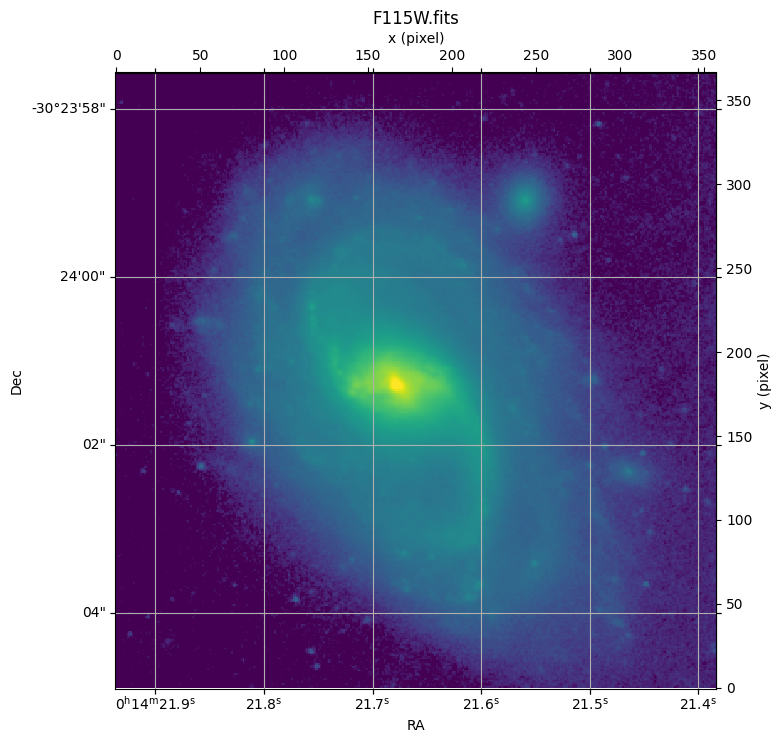

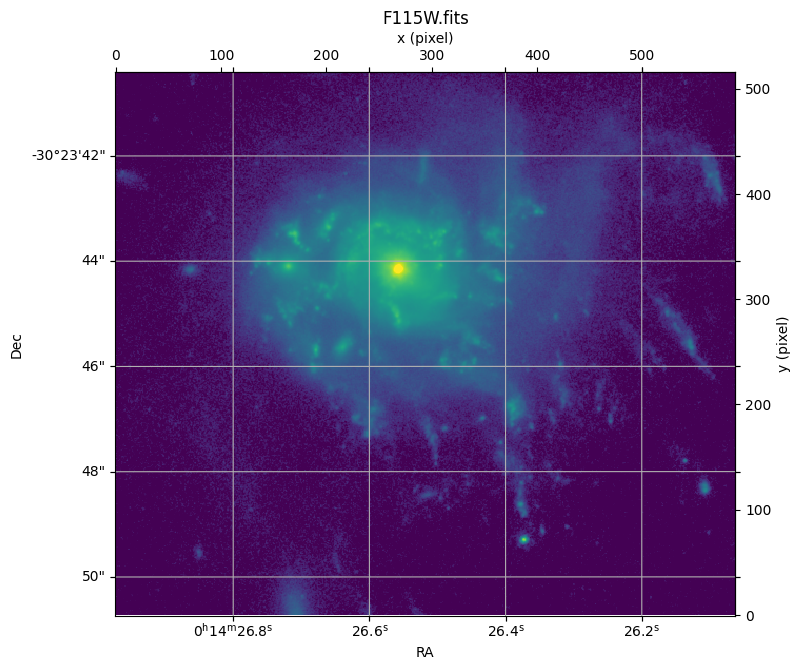

In [10]:
# Visualize a specific filter of the fits 
base_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/"
filt = "F115W"

for region in sorted(os.listdir(base_dir)):
    region_path = os.path.join(base_dir, region, "NIRCam")
    if not os.path.isdir(region_path):
        continue

    fits_file = os.path.join(region_path, f"{filt}.fits")
    if not os.path.exists(fits_file):
        print(f"{fits_file} not found, skipping.")
        continue

    visualize_fits(
        fits_file,
        save_path=None,
        stretch="log",
        min_percent=25.,
        max_percent=99.98
    )

##### 3) Align and create datacubes

In [11]:
# Align fits and build datacubes (one per galaxy and per instrument)
base_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/"
subfolders = ['NIRCam', 'ACS', 'WFC3-IR', 'WFC3-UV']

# Loop over galaxies
for gal_name in os.listdir(base_dir):
    gal_path = os.path.join(base_dir, gal_name)
    if not os.path.isdir(gal_path):
        continue

    print(f"\nProcessing galaxy: {gal_name}")

    # Loop over instruments
    for sub in subfolders:
        folder_path = os.path.join(gal_path, sub)
        if not os.path.isdir(folder_path):
            continue

        fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
        if not fits_files:
            print(f'  No FITS files found in {folder_path}. Skipping.')
            continue

        fits_list = [(f, infer_filter(f)) for f in fits_files]
        fits_list_sorted = sorted(fits_list, key=lambda x: get_filter(x[1]))

        ref_file = fits_list_sorted[0][0]
        print(f"  Aligning {len(fits_list_sorted)} files in {sub}...")

        aligned_fits = align_fits(fits_list_sorted, ref_file)

        output_cube = os.path.join(folder_path, f'datacube_{sub.lower()}.fits')
        build_datacube(aligned_fits, ref_file, output_cube)

        print(f'  Datacube saved at {output_cube}')

        # In case you need to convert units:
        # aligned = align_fits(fits_list_sorted, ref_file)
        # aligned_jy = MJy_sr_to_jy(aligned)
        # build_datacube(aligned_jy, ref_file, output_cube)


Processing galaxy: region_1
  Aligning 20 files in NIRCam...
Filter F070W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F070W_aligned.fits
Filter F090W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F090W_aligned.fits
Filter F115W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F115W_aligned.fits
Filter F140M: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F140M_aligned.fits
Filter F150W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F150W_aligned.fits
Filter F162M: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F162M_aligned.fits
Filter F182M: unit = 10.0*nanoJansky
Saved: /home/andressa/Dou

/home/andressa/github/fits/datacube.py:321: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[0] = wcs_2d.wcs.cdelt[0]
/home/andressa/github/fits/datacube.py:322: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[1] = wcs_2d.wcs.cdelt[1]
/home/andressa/github/fits/datacube.py:336: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[2] = 1


Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/datacube_nircam.fits
  Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/datacube_nircam.fits
  Aligning 3 files in ACS...
Filter F435W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/ACS/F435W_aligned.fits
Filter F606W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/ACS/F606W_aligned.fits
Filter F814W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/ACS/F814W_aligned.fits
Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/ACS/datacube_acs.fits
  Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/ACS/datacube_acs.fits
  Aligning 4 files in WFC3-IR...
Filter F105W: unit = 10.0*nan

/home/andressa/github/fits/datacube.py:321: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[0] = wcs_2d.wcs.cdelt[0]
/home/andressa/github/fits/datacube.py:322: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[1] = wcs_2d.wcs.cdelt[1]
/home/andressa/github/fits/datacube.py:336: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[2] = 1


Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-IR/F140W_aligned.fits
Filter F160W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-IR/F160W_aligned.fits
Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-IR/datacube_wfc3-ir.fits
  Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-IR/datacube_wfc3-ir.fits
  Aligning 3 files in WFC3-UV...
Filter F225W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-UV/F225W_aligned.fits
Filter F275W: unit = 10.0*nanoJansky


/home/andressa/github/fits/datacube.py:321: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[0] = wcs_2d.wcs.cdelt[0]
/home/andressa/github/fits/datacube.py:322: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[1] = wcs_2d.wcs.cdelt[1]
/home/andressa/github/fits/datacube.py:336: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[2] = 1


Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-UV/F275W_aligned.fits
Filter F336W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-UV/F336W_aligned.fits
Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-UV/datacube_wfc3-uv.fits
  Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-UV/datacube_wfc3-uv.fits

Processing galaxy: region_0
  Aligning 20 files in NIRCam...


/home/andressa/github/fits/datacube.py:321: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[0] = wcs_2d.wcs.cdelt[0]
/home/andressa/github/fits/datacube.py:322: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[1] = wcs_2d.wcs.cdelt[1]
/home/andressa/github/fits/datacube.py:336: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[2] = 1


Filter F070W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F070W_aligned.fits
Filter F090W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F090W_aligned.fits
Filter F115W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F115W_aligned.fits
Filter F140M: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F140M_aligned.fits
Filter F150W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F150W_aligned.fits
Filter F162M: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/F162M_aligned.fits
Filter F182M: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRC

/home/andressa/github/fits/datacube.py:321: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[0] = wcs_2d.wcs.cdelt[0]
/home/andressa/github/fits/datacube.py:322: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[1] = wcs_2d.wcs.cdelt[1]
/home/andressa/github/fits/datacube.py:336: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[2] = 1
/home/andressa/github/fits/datacube.py:321: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[0] = wcs_2d.wcs.cdelt[0]
/home/andressa/github/fits/datacube.py:322: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[1] = wcs_2d.wcs.cdelt[1]
/home/andressa/github/fits/datacube.py:336: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[2] = 1


Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_nircam.fits
  Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_nircam.fits
  Aligning 3 files in ACS...
Filter F435W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/ACS/F435W_aligned.fits
Filter F606W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/ACS/F606W_aligned.fits
Filter F814W: unit = 10.0*nanoJansky
Saved: /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/ACS/F814W_aligned.fits
Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/ACS/datacube_acs.fits
  Datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/ACS/datacube_acs.fits
  Aligning 4 files in WFC3-IR...
Filter F105W: unit = 10.0*nan

/home/andressa/github/fits/datacube.py:321: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[0] = wcs_2d.wcs.cdelt[0]
/home/andressa/github/fits/datacube.py:322: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[1] = wcs_2d.wcs.cdelt[1]
/home/andressa/github/fits/datacube.py:336: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[2] = 1
/home/andressa/github/fits/datacube.py:321: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[0] = wcs_2d.wcs.cdelt[0]
/home/andressa/github/fits/datacube.py:322: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[1] = wcs_2d.wcs.cdelt[1]
/home/andressa/github/fits/datacube.py:336: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_3d.wcs.cdelt[2] = 1


##### 4) Delete empty filters in the datacube


In [26]:
base_dir = '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/'

for gal_name in os.listdir(base_dir):
    gal_path = os.path.join(base_dir, gal_name)
    if not os.path.isdir(gal_path):
        continue

    print(f"\nProcessing galaxy: {gal_name}")

    datacubes = glob.glob(os.path.join(gal_path, '*', 'datacube_*.fits'))
    if not datacubes:
        print("  No datacubes found. Skipping.")
        continue

    for cube_file in datacubes:
        folder = os.path.dirname(cube_file)
        output_cube = os.path.join(folder, 'datacube_filtered.fits')
        cube_filtered, filters_valid = build_valid_datacube(
            cube_fits_file=cube_file,
            output_cube=output_cube,
            threshold=0.0,
            frac_valid=0.01
        )


Processing galaxy: region_1
Filtered datacube saved at '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-UV/datacube_filtered.fits'
Filtered datacube saved at '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/datacube_filtered.fits'
Filtered datacube saved at '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/WFC3-IR/datacube_filtered.fits'
Filtered datacube saved at '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/ACS/datacube_filtered.fits'

Processing galaxy: region_0
Filtered datacube saved at '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/WFC3-UV/datacube_filtered.fits'
Filtered datacube saved at '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_filtered.fits'
Filtered datacube saved at '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/WFC3-IR/datacube_filtered.fi

##### If you still need to remove a specific filter

In [37]:
base_dir = '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_filtered.fits'
output = '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_filtered_.fits'

cube_new, new_filters = remove_filter(
    cube_fits_file=base_dir,
    output_cube=output,
    filter_to_remove="F300M"
)

Removing filter: F300M
New datacube without 'F300M' saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_filtered_.fits


##### 5) Cut a region in a datacube

This cut is based in pixels coordinates (you can set them).

In [19]:
# example for region_0
y_min = 150
y_max = 250
x_min = 150
x_max = 250

path =  '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_nircam.fits'
output_dir = '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/'

cut_region(cube_fits_file=path, 
           x_start=x_min, x_end=x_max, 
           y_start=y_min, y_end=y_max, 
           output_path=output_dir+'cut_datacube_nircam.fits')

Cut datacube saved to '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/cut_datacube_nircam.fits'


##### Or cut more than one region
The region coordinates must be written in a .csv file

In [20]:
df_boxes = pd.read_csv('/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/cuts.csv')
print(df_boxes)

for i, row in df_boxes.iterrows():
    x_min = int(row['x_min'])
    x_max   = int(row['x_max'])
    y_min = int(row['y_min'])
    y_max   = int(row['y_max'])

    output_filename = f'datacube_nircam_box_{i:02d}.fits'

    cut_region(cube_fits_file=path,
               x_start=x_min, x_end=x_max,
               y_start=y_min, y_end=y_max,
               output_path=output_dir+output_filename)

   x_min  x_max  y_min  y_max
0    160    220    180    220
1    140    170    140    180
Cut datacube saved to '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_nircam_box_00.fits'
Cut datacube saved to '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_nircam_box_01.fits'


##### 6) Visualize all the filters in a datacube

Number of filters: 20


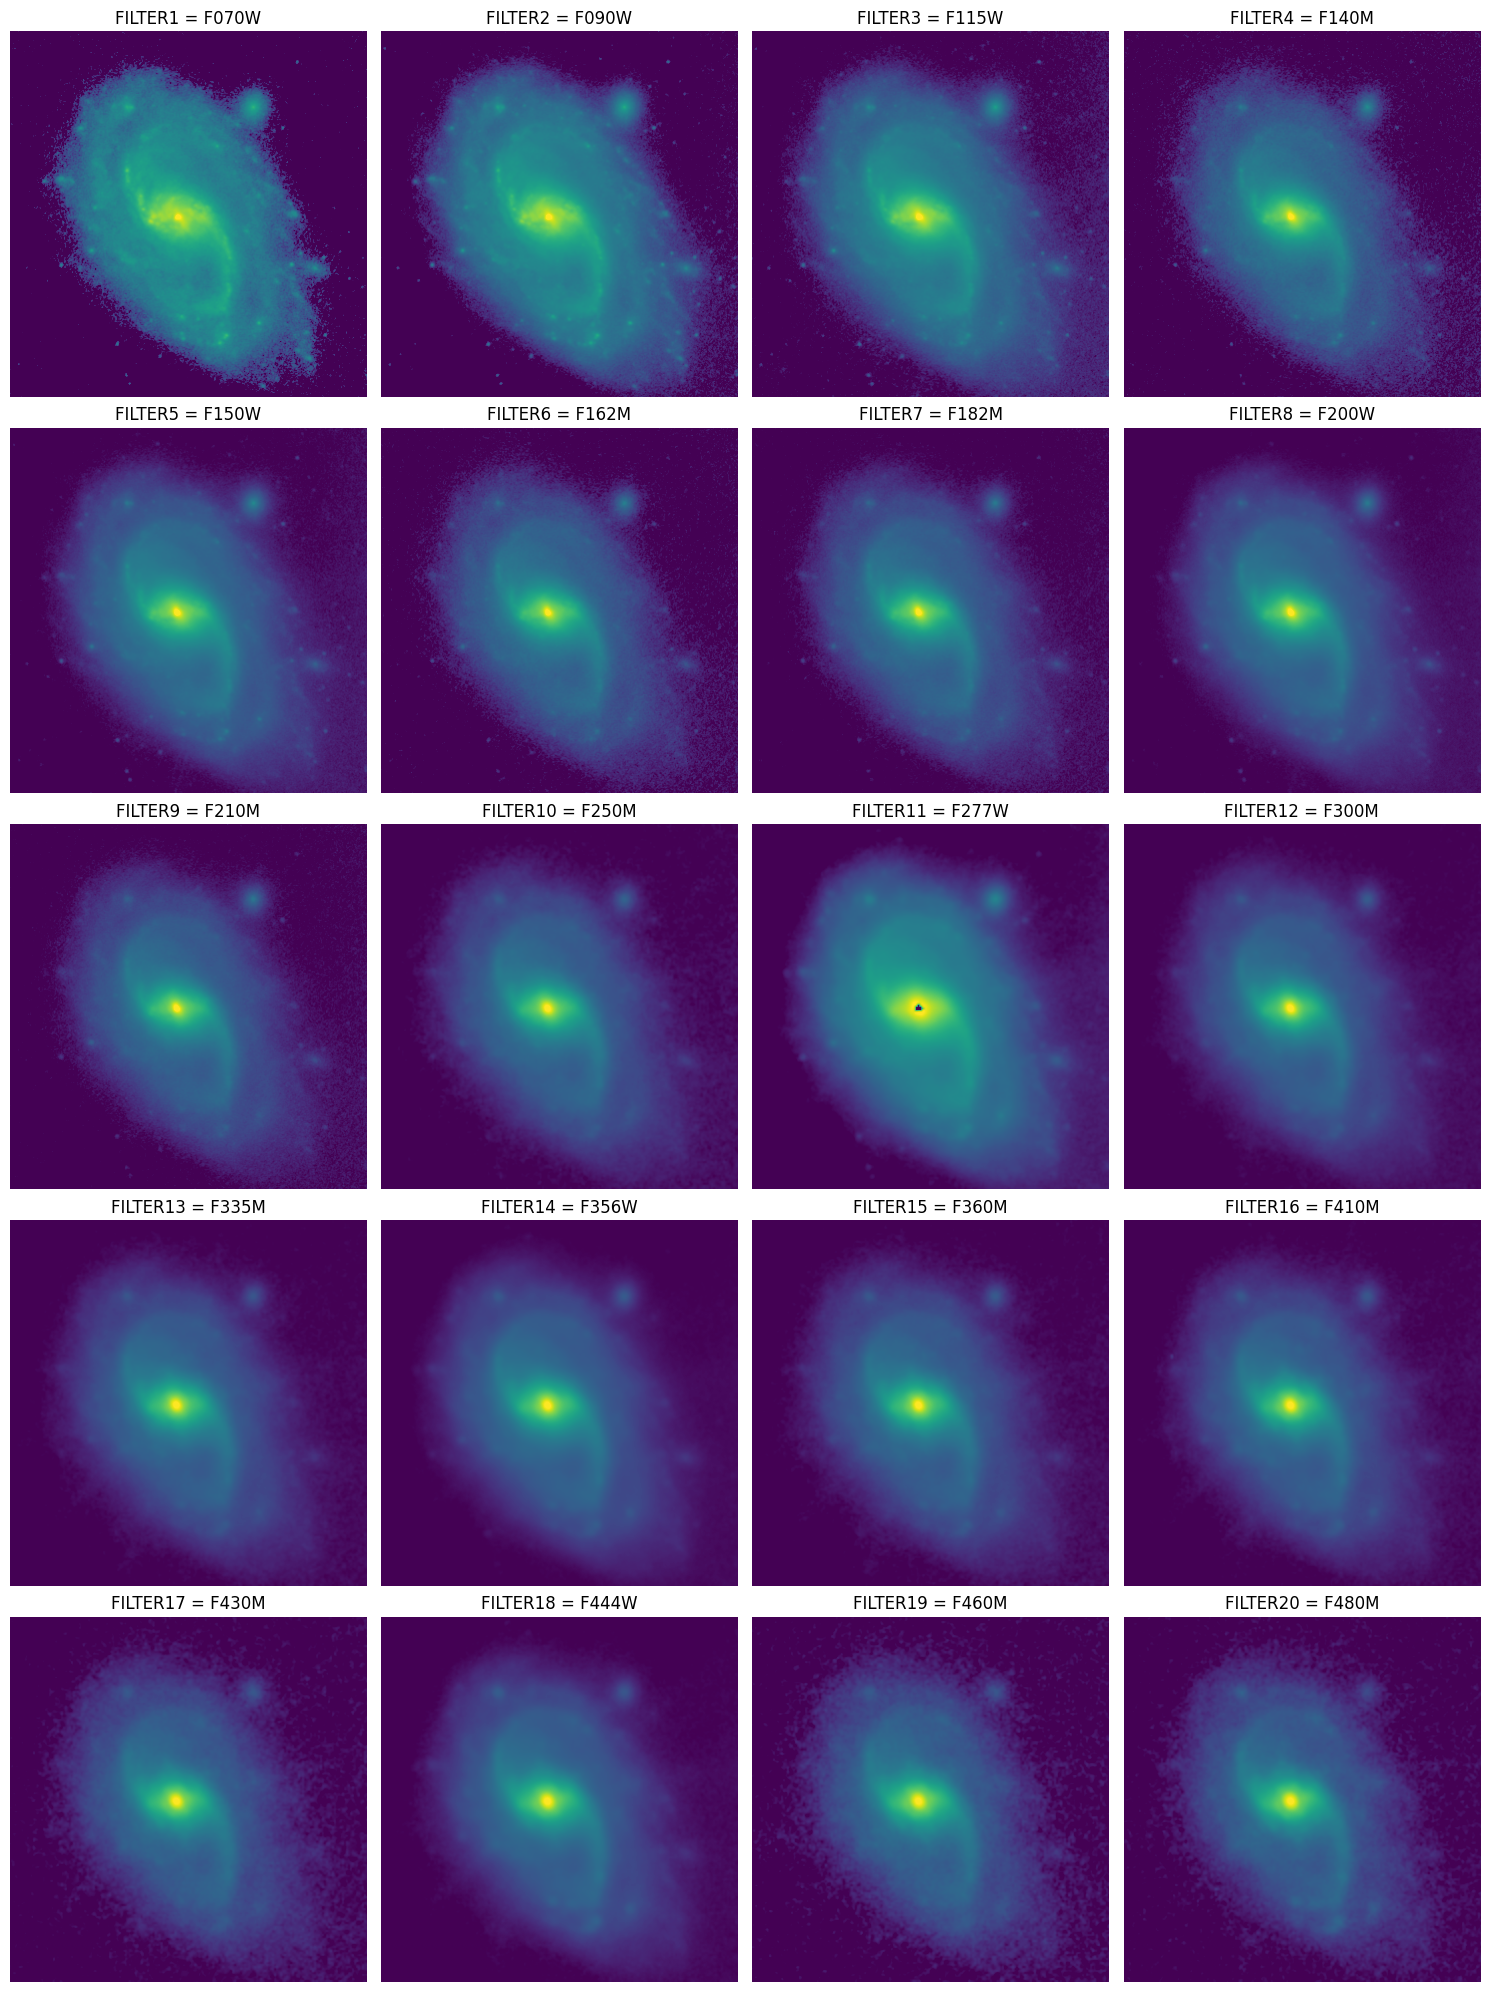

In [40]:
# example for region_0
datacube_file = "/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_0/NIRCam/datacube_nircam.fits"

with fits.open(datacube_file) as hdul:
    datacube = hdul[0].data     
    header = hdul[0].header
    
n_filters = datacube.shape[0]
print(f'Number of filters: {n_filters}')
filters = [header[f"FILTER{i+1}"] for i in range(n_filters)]

fig, axes = plt.subplots(5, 4, figsize=(15, 20))
axes = axes.flatten()

for i in range(n_filters):
    ax = axes[i]
    data = datacube[i, :, :]

    mask = np.logical_or(np.isnan(data), data <= 0.)
    norm = simple_norm(data[~mask], stretch='log',
                       min_percent=25., max_percent=99.98)
    
    ax.imshow(data, origin='lower', cmap='viridis', norm=norm)
    ax.set_title(f'FILTER{i+1} = {filters[i]}')
    ax.axis("off")

for j in range(n_filters, len(axes)):
    axes[j].axis("off")
    
plt.tight_layout()
plt.show()
#plt.savefig('path_to_save.png', dpi=200)